In [1]:
# Para las mediciones realizadas en este trabajo

T_FILE = "../Mediciones/tiempos_2.bin"
O_FILE = "../Mediciones/sic_phi.bin"
T1_OUT_FILE = "../Mediciones/t1.bin"

# Para las mediciones realizadas en la tesis

# T_FILE = "../data/tiempos.bin"
# O_FILE = "../data/sic_phi.bin"
# T1_OUT_FILE = "../data/t1.bin"

In [2]:
from read_times import read_times
import matplotlib.pyplot as plt
import numpy as np
import time
from estimate_phi import phi_estimation
from estimate_phi import interpolate_missing_values
from median_calculator import median_window
from estimate_phi import linear_reg
from estimate_phi import arma_filter

In [3]:
t1, t2, t3, t4 = read_times(T_FILE)

Estimar $\Phi$ como $\Phi = (t_1-t_2-t_3+t_4)/2$

In [4]:
phi_est = phi_estimation(t1, t2, t3, t4)

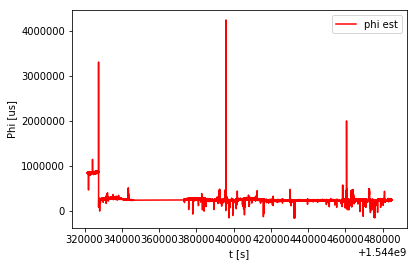

In [5]:
start = 0
end = -1
plt.plot(t1[start:end]/1e6,phi_est[start:end],c='r')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi est',''));

Completamos los segundos que faltan interpolando linealmente:

In [6]:
t1, phi_est = interpolate_missing_values(t1, phi_est)

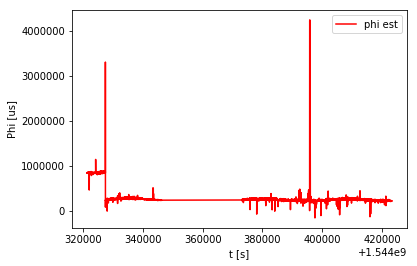

In [7]:
start = 0
end = 100000
plt.plot(t1[start:end]/1e6,phi_est[start:end],c='r')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi est',''));

Para eliminar los picos, suavizamos reemplazando cada punto con la mediana de una ventana de 600 segundos

In [8]:
phi_med_600 = median_window(phi_est, 600)
phi_med_600 = np.array(phi_med_600)
t1 = t1[:len(phi_med_600)]

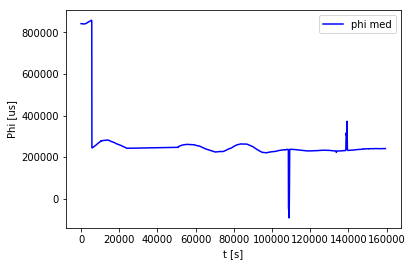

In [9]:
start = 0
end = start + -1
plt.plot(phi_med_600[start:end],c='b')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med',''));

Nuevamente, suavizamos los datos con una regresión lineal en ventanas de 60 segundos:

In [10]:
# cortamos los datos para que entre un número entero de ventanas
phi_med_600 = phi_med_600[:len(phi_med_600)//60*60]
t1 = t1[:len(phi_med_600)]
t1.tofile(T1_OUT_FILE)

In [11]:
f_lin, k_lin = linear_reg(t1, phi_med_600, 60)
phi_lin = np.zeros(len(t1))
for i in range(len(t1) // 60):
    phi_lin[i * 60:(i + 1) * 60] = t1[i * 60:(i + 1) * 60] * f_lin[i] + k_lin[i]

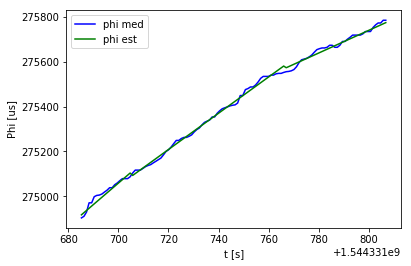

In [12]:
start = 10000
end = start + 120
plt.plot(t1[start:end]/1e6,phi_med_600[start:end],c='b');
plt.plot(t1[start:end]/1e6,phi_lin[start:end],c='g')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med', 'phi est'));

Aplicamos un filtro ARMA para que cada recta dependa de las anteriores:

In [13]:
alpha = 0.15
f, k = arma_filter(f_lin, k_lin, alpha)
phi_arma = np.zeros(len(t1))
for i in range(len(t1) // 60):
    phi_arma[i * 60:(i + 1) * 60] = t1[i * 60:(i + 1) * 60] * f[i] + k[i]

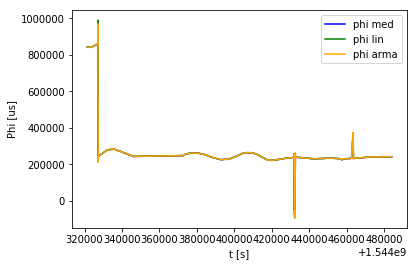

In [14]:
start = 0
end = -1
plt.plot(t1[start:end]/1e6,phi_med_600[start:end],c='b')
plt.plot(t1[start:end]/1e6,phi_lin[start:end],c='g')
plt.plot(t1[start:end]/1e6,phi_arma[start:end],c='orange')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med','phi lin', 'phi arma'));

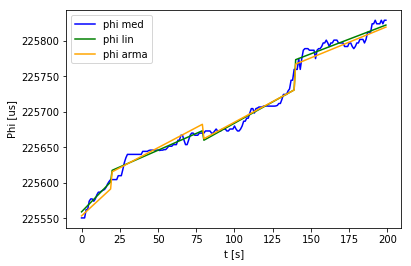

In [15]:
start = 100000
end = 100200
plt.plot(phi_med_600[start:end],c='b')
plt.plot(phi_lin[start:end],c='g')
plt.plot(phi_arma[start:end],c='orange')
plt.xlabel('t [s]')
plt.ylabel('Phi [us]')
plt.legend(('phi med','phi lin', 'phi arma'));

In [16]:
# Antes de guardar, pasamos el phi obtenido a segundos
phi_arma = phi_arma/1e6

In [17]:
phi_arma.tofile(O_FILE)